
Processing RELIANCE.NS...



[*********************100%%**********************]  1 of 1 completed


Training data range: 2010-01-04 00:00:00 to 2020-06-23 00:00:00
Testing data range: 2020-06-24 00:00:00 to 2022-12-30 00:00:00
Epoch [1/10], Loss: 0.0590
Epoch [2/10], Loss: 0.0055
Epoch [3/10], Loss: 0.0007
Epoch [4/10], Loss: 0.0003
Epoch [5/10], Loss: 0.0001
Epoch [6/10], Loss: 0.0002
Epoch [7/10], Loss: 0.0003
Epoch [8/10], Loss: 0.0008
Epoch [9/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0002


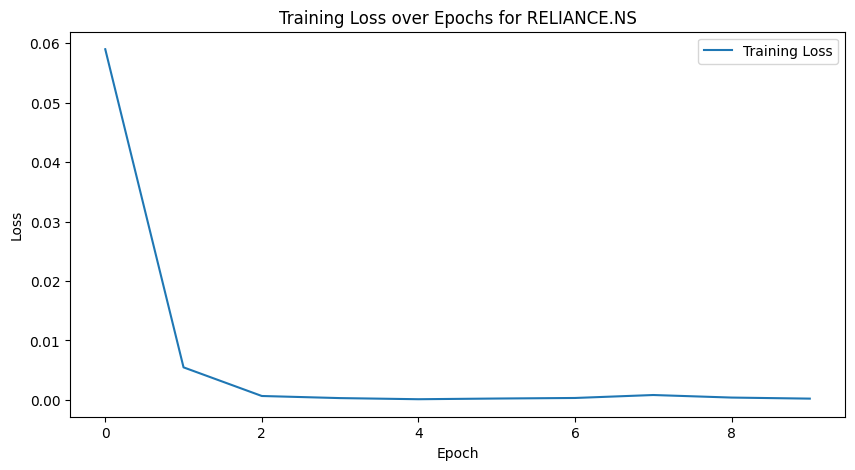

RELIANCE.NS - Mean Squared Error: 0.01407027430832386
RELIANCE.NS - Mean Absolute Error: 0.09860911220312119


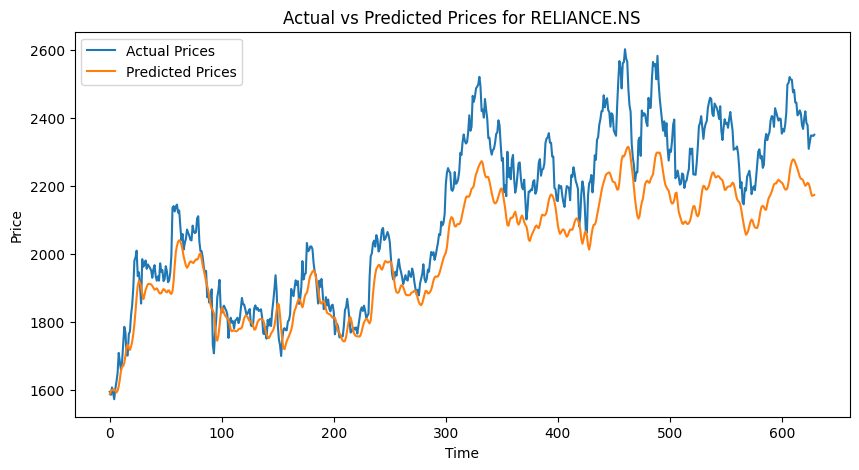


Processing TCS.NS...



[*********************100%%**********************]  1 of 1 completed


Training data range: 2010-01-04 00:00:00 to 2020-06-23 00:00:00
Testing data range: 2020-06-24 00:00:00 to 2022-12-30 00:00:00
Epoch [1/10], Loss: 0.0314
Epoch [2/10], Loss: 0.0004
Epoch [3/10], Loss: 0.0003
Epoch [4/10], Loss: 0.0003
Epoch [5/10], Loss: 0.0008
Epoch [6/10], Loss: 0.0003
Epoch [7/10], Loss: 0.0003
Epoch [8/10], Loss: 0.0002
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0003


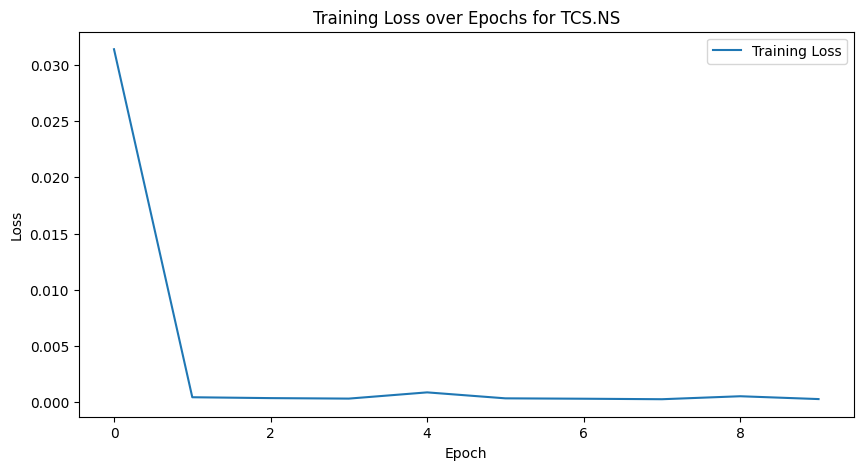

TCS.NS - Mean Squared Error: 0.013824435882270336
TCS.NS - Mean Absolute Error: 0.1018923819065094


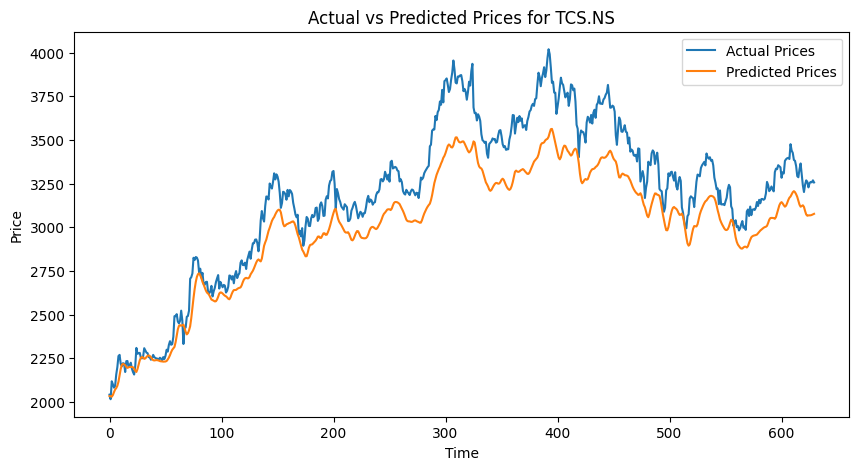

[*********************100%%**********************]  1 of 1 completed


Processing ADANIGREEN.NS...

Training data range: 2018-06-18 00:00:00 to 2022-02-21 00:00:00
Testing data range: 2022-02-22 00:00:00 to 2022-12-30 00:00:00


Epoch [1/10], Loss: 0.0457
Epoch [2/10], Loss: 0.0796
Epoch [3/10], Loss: 0.0191
Epoch [4/10], Loss: 0.0038
Epoch [5/10], Loss: 0.0045
Epoch [6/10], Loss: 0.0013
Epoch [7/10], Loss: 0.0002
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0010
Epoch [10/10], Loss: 0.0016


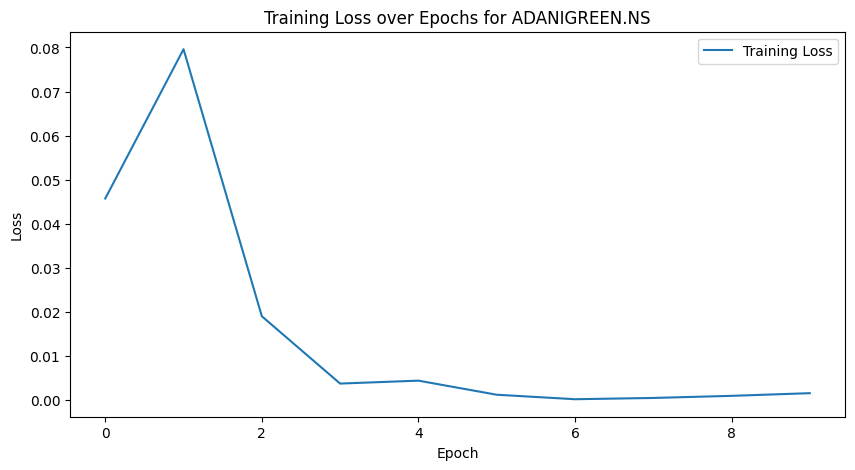

ADANIGREEN.NS - Mean Squared Error: 0.007046428043395281
ADANIGREEN.NS - Mean Absolute Error: 0.057614412158727646


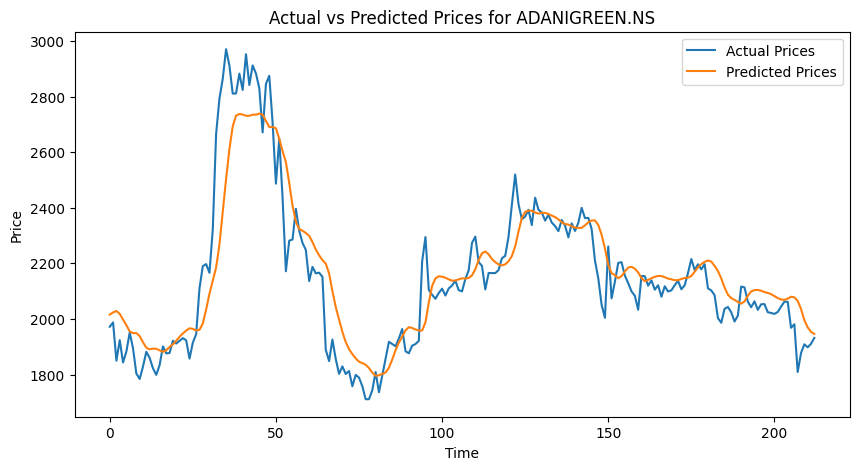

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.autograd import Variable
import matplotlib.pyplot as plt

# 1. Download the data
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# 2. Preprocess the data
def preprocess_data(data):
    data = data[['Close']]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# 3. Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 4. Define the LTCN model
class LTCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LTCN, self).__init__()
        self.hidden_size = hidden_size
        self.ltc = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(x.device)
        out, hn = self.ltc(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 5. Train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs, device):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        for sequences, targets in train_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return loss_list

# 6. Evaluate the model
def evaluate_model(model, criterion, test_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            outputs = model(sequences)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    return predictions, actuals, mse, mae

# 7. Main function to prepare data, create the model, train and test it
def main(tickers, start_date='2010-01-01', end_date='2023-01-01'):
    seq_length = 60
    batch_size = 64
    hidden_size = 50
    num_epochs = 10
    learning_rate = 0.001

    results = {}

    for ticker in tickers:
        print(f"\nProcessing {ticker}...\n")
        data = download_data(ticker, start_date, end_date)
        scaled_data, scaler = preprocess_data(data)
        xs, ys = create_sequences(scaled_data, seq_length)

        # Split data into train and test sets
        train_size = int(len(xs) * 0.8)
        test_size = len(xs) - train_size
        train_xs, test_xs = xs[:train_size], xs[train_size:]
        train_ys, test_ys = ys[:train_size], ys[train_size:]

        # Print the date ranges for training and testing
        train_dates = data.index[:train_size + seq_length]
        test_dates = data.index[train_size + seq_length:]

        print(f'Training data range: {train_dates[0]} to {train_dates[-1]}')
        print(f'Testing data range: {test_dates[0]} to {test_dates[-1]}')

        train_xs = torch.tensor(train_xs, dtype=torch.float32)
        train_ys = torch.tensor(train_ys, dtype=torch.float32)
        test_xs = torch.tensor(test_xs, dtype=torch.float32)
        test_ys = torch.tensor(test_ys, dtype=torch.float32)

        train_dataset = torch.utils.data.TensorDataset(train_xs, train_ys)
        test_dataset = torch.utils.data.TensorDataset(test_xs, test_ys)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        input_size = train_xs.shape[2]
        output_size = 1

        model = LTCN(input_size, hidden_size, output_size).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        loss_list = train_model(model, criterion, optimizer, train_loader, num_epochs, device)

        # Save the model
        torch.save(model.state_dict(), f'{ticker}_ltcn_model.pth')

        # Plot the loss curve
        plt.figure(figsize=(10, 5))
        plt.plot(loss_list, label='Training Loss')
        plt.title(f'Training Loss over Epochs for {ticker}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Evaluate the model
        predictions, actuals, mse, mae = evaluate_model(model, criterion, test_loader, device)
        predictions = scaler.inverse_transform(predictions)
        actuals = scaler.inverse_transform(actuals)

        print(f'{ticker} - Mean Squared Error: {mse}')
        print(f'{ticker} - Mean Absolute Error: {mae}')

        # Plot the predicted vs actual prices
        plt.figure(figsize=(10, 5))
        plt.plot(actuals, label='Actual Prices')
        plt.plot(predictions, label='Predicted Prices')
        plt.title(f'Actual vs Predicted Prices for {ticker}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

        results[ticker] = {
            'mse': mse,
            'mae': mae,
            'actuals': actuals,
            'predictions': predictions
        }

    return results

if __name__ == "__main__":
    tickers = ['RELIANCE.NS', 'TCS.NS', 'ADANIGREEN.NS']
    results = main(tickers)

# **Intraday**


Processing RELIANCE.NS...



[*********************100%%**********************]  1 of 1 completed


Training data range: 2024-07-29 09:15:00+05:30 to 2024-08-02 09:26:00+05:30
Testing data range: 2024-08-02 09:27:00+05:30 to 2024-08-02 15:29:00+05:30
Epoch [1/10], Loss: 0.0133
Epoch [2/10], Loss: 0.0031
Epoch [3/10], Loss: 0.0085
Epoch [4/10], Loss: 0.0018
Epoch [5/10], Loss: 0.0039
Epoch [6/10], Loss: 0.0024
Epoch [7/10], Loss: 0.0031
Epoch [8/10], Loss: 0.0026
Epoch [9/10], Loss: 0.0023
Epoch [10/10], Loss: 0.0018


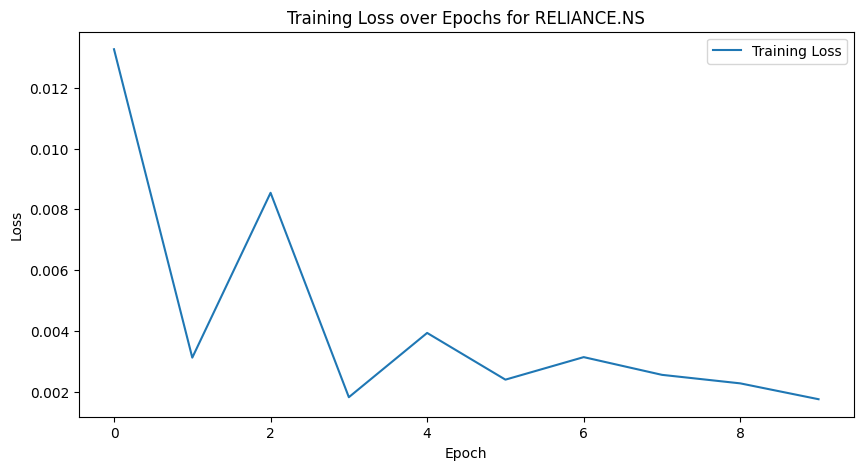

RELIANCE.NS - Mean Squared Error: 0.0035864156670868397
RELIANCE.NS - Mean Absolute Error: 0.04490305855870247


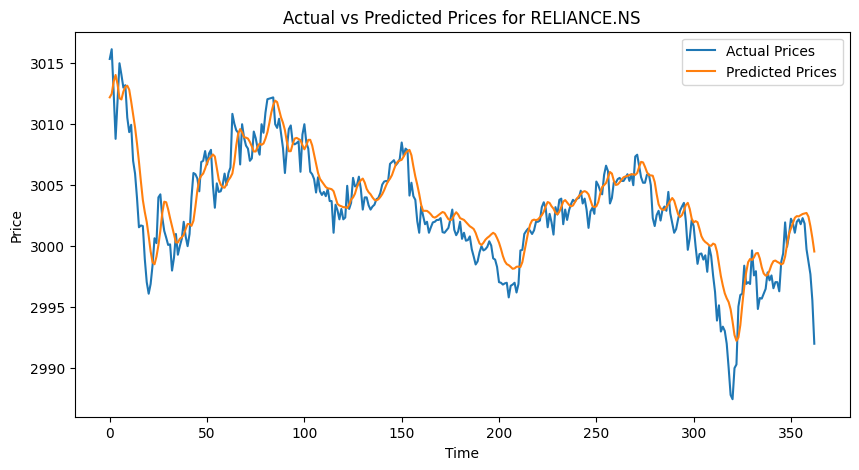

[*********************100%%**********************]  1 of 1 completed


Processing TCS.NS...

Training data range: 2024-07-29 09:15:00+05:30 to 2024-08-02 09:26:00+05:30
Testing data range: 2024-08-02 09:27:00+05:30 to 2024-08-02 15:29:00+05:30


Epoch [1/10], Loss: 0.0493
Epoch [2/10], Loss: 0.0144
Epoch [3/10], Loss: 0.0015
Epoch [4/10], Loss: 0.0022
Epoch [5/10], Loss: 0.0012
Epoch [6/10], Loss: 0.0017
Epoch [7/10], Loss: 0.0016
Epoch [8/10], Loss: 0.0013
Epoch [9/10], Loss: 0.0017
Epoch [10/10], Loss: 0.0013


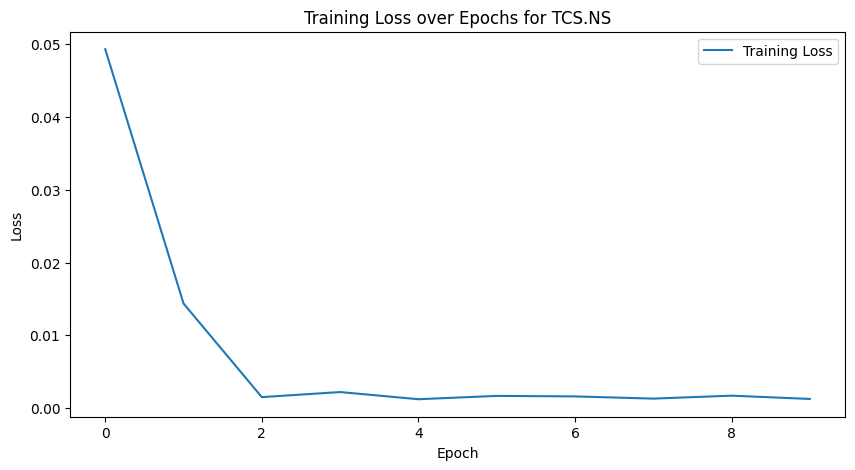

TCS.NS - Mean Squared Error: 0.010640434920787811
TCS.NS - Mean Absolute Error: 0.08759640157222748


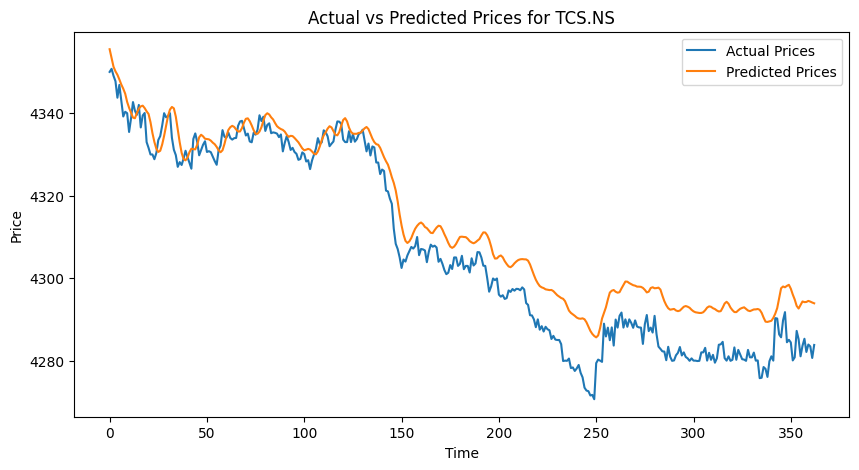

[*********************100%%**********************]  1 of 1 completed


Processing ADANIGREEN.NS...

Training data range: 2024-07-29 09:15:00+05:30 to 2024-08-02 09:26:00+05:30
Testing data range: 2024-08-02 09:27:00+05:30 to 2024-08-02 15:29:00+05:30


Epoch [1/10], Loss: 0.0099
Epoch [2/10], Loss: 0.0117
Epoch [3/10], Loss: 0.0056
Epoch [4/10], Loss: 0.0023
Epoch [5/10], Loss: 0.0019
Epoch [6/10], Loss: 0.0040
Epoch [7/10], Loss: 0.0067
Epoch [8/10], Loss: 0.0021
Epoch [9/10], Loss: 0.0029
Epoch [10/10], Loss: 0.0051


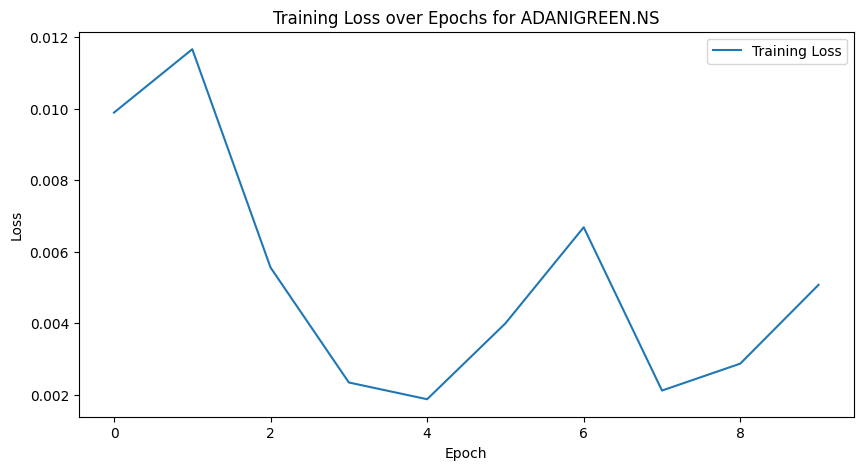

ADANIGREEN.NS - Mean Squared Error: 0.001500441343523562
ADANIGREEN.NS - Mean Absolute Error: 0.029444457963109016


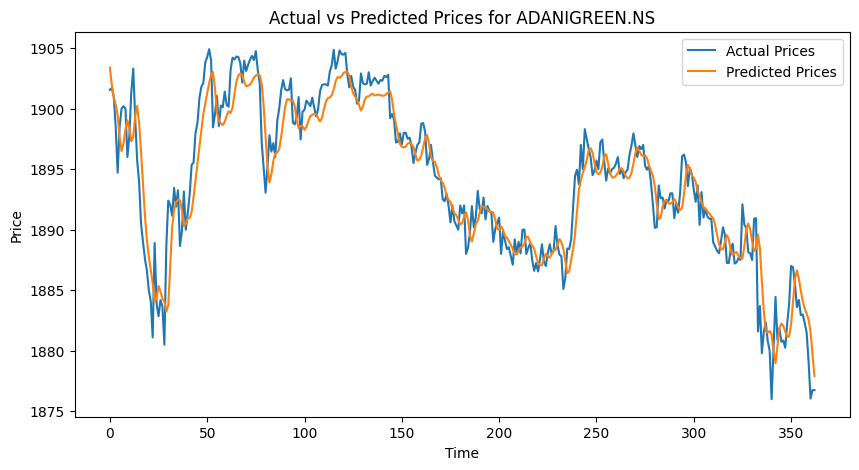

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.autograd import Variable
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. Download the data in chunks
def download_data_in_chunks(ticker, start_date, end_date, interval='1m', chunk_size=7):
    data = pd.DataFrame()
    date_range = pd.date_range(start=start_date, end=end_date, freq=f'{chunk_size}D')
    for i in range(len(date_range)-1):
        start = date_range[i]
        end = date_range[i+1] - timedelta(days=1)
        chunk_data = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), interval=interval)
        data = pd.concat([data, chunk_data])
    return data

# 2. Preprocess the data
def preprocess_data(data):
    data = data[['Close']]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# 3. Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 4. Define the LTCN model
class LTCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LTCN, self).__init__()
        self.hidden_size = hidden_size
        self.ltc = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(x.device)
        out, hn = self.ltc(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 5. Train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs, device):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        for sequences, targets in train_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return loss_list

# 6. Evaluate the model
def evaluate_model(model, criterion, test_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            outputs = model(sequences)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    return predictions, actuals, mse, mae

# 7. Main function to prepare data, create the model, train and test it
def main(tickers, start_date=None, end_date=None, interval='1m'):
    seq_length = 60
    batch_size = 64
    hidden_size = 50
    num_epochs = 10
    learning_rate = 0.001

    if start_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
        start_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')
    elif end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    results = {}

    for ticker in tickers:
        print(f"\nProcessing {ticker}...\n")
        data = download_data_in_chunks(ticker, start_date, end_date, interval=interval)
        if data.empty:
            print(f"No data found for {ticker} in the given date range.")
            continue

        scaled_data, scaler = preprocess_data(data)
        xs, ys = create_sequences(scaled_data, seq_length)

        # Split data into train and test sets
        train_size = int(len(xs) * 0.8)
        test_size = len(xs) - train_size
        train_xs, test_xs = xs[:train_size], xs[train_size:]
        train_ys, test_ys = ys[:train_size], ys[train_size:]

        # Print the date ranges for training and testing
        train_dates = data.index[:train_size + seq_length]
        test_dates = data.index[train_size + seq_length:]

        print(f'Training data range: {train_dates[0]} to {train_dates[-1]}')
        print(f'Testing data range: {test_dates[0]} to {test_dates[-1]}')

        train_xs = torch.tensor(train_xs, dtype=torch.float32)
        train_ys = torch.tensor(train_ys, dtype=torch.float32)
        test_xs = torch.tensor(test_xs, dtype=torch.float32)
        test_ys = torch.tensor(test_ys, dtype=torch.float32)

        train_dataset = torch.utils.data.TensorDataset(train_xs, train_ys)
        test_dataset = torch.utils.data.TensorDataset(test_xs, test_ys)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        input_size = train_xs.shape[2]
        output_size = 1

        model = LTCN(input_size, hidden_size, output_size).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        loss_list = train_model(model, criterion, optimizer, train_loader, num_epochs, device)

        # Save the model
        torch.save(model.state_dict(), f'{ticker}_ltcn_model.pth')

        # Plot the loss curve
        plt.figure(figsize=(10, 5))
        plt.plot(loss_list, label='Training Loss')
        plt.title(f'Training Loss over Epochs for {ticker}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Evaluate the model
        predictions, actuals, mse, mae = evaluate_model(model, criterion, test_loader, device)
        predictions = scaler.inverse_transform(predictions)
        actuals = scaler.inverse_transform(actuals)

        print(f'{ticker} - Mean Squared Error: {mse}')
        print(f'{ticker} - Mean Absolute Error: {mae}')

        # Plot the predicted vs actual prices
        plt.figure(figsize=(10, 5))
        plt.plot(actuals, label='Actual Prices')
        plt.plot(predictions, label='Predicted Prices')
        plt.title(f'Actual vs Predicted Prices for {ticker}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

        results[ticker] = {
            'mse': mse,
            'mae': mae,
            'actuals': actuals,
            'predictions': predictions
        }

    return results

if __name__ == "__main__":
    tickers = ['RELIANCE.NS', 'TCS.NS', 'ADANIGREEN.NS']
    results = main(tickers, interval='1m')



Processing RELIANCE.NS...



[*********************100%%**********************]  1 of 1 completed


Training data range: 2024-07-29 09:15:00+05:30 to 2024-08-02 09:26:00+05:30
Testing data range: 2024-08-02 09:27:00+05:30 to 2024-08-02 15:29:00+05:30
Epoch [1/10], Loss: 0.0173
Epoch [2/10], Loss: 0.0036
Epoch [3/10], Loss: 0.0022
Epoch [4/10], Loss: 0.0054
Epoch [5/10], Loss: 0.0029
Epoch [6/10], Loss: 0.0020
Epoch [7/10], Loss: 0.0045
Epoch [8/10], Loss: 0.0025
Epoch [9/10], Loss: 0.0033
Epoch [10/10], Loss: 0.0024


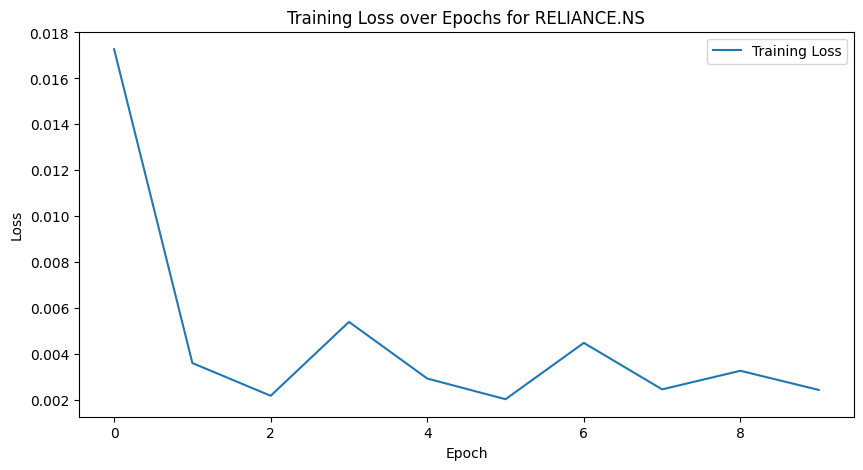

RELIANCE.NS - Mean Squared Error: 0.004694334231317043
RELIANCE.NS - Mean Absolute Error: 0.05420270189642906


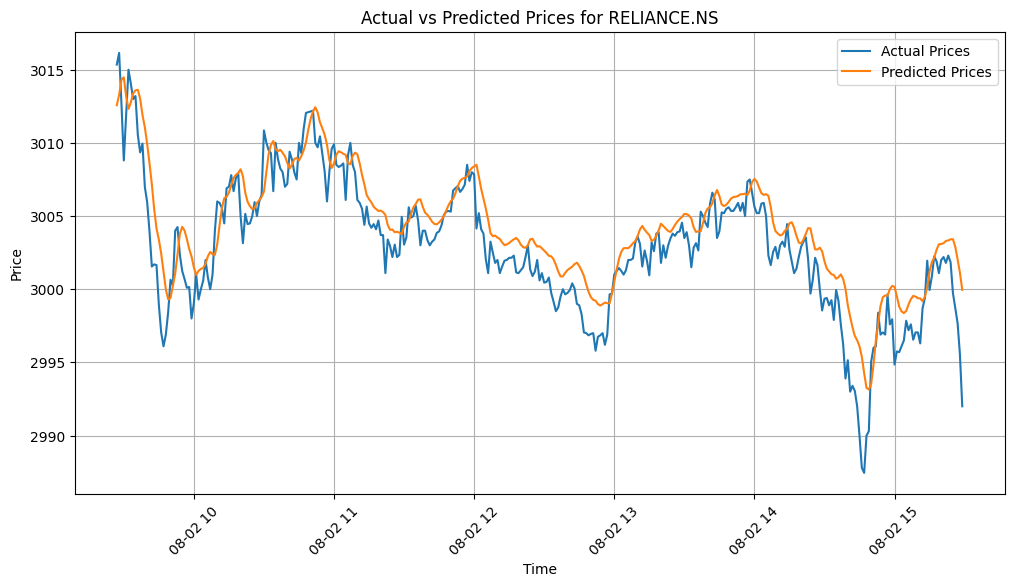

[*********************100%%**********************]  1 of 1 completed


Processing TCS.NS...

Training data range: 2024-07-29 09:15:00+05:30 to 2024-08-02 09:26:00+05:30
Testing data range: 2024-08-02 09:27:00+05:30 to 2024-08-02 15:29:00+05:30


Epoch [1/10], Loss: 0.0236
Epoch [2/10], Loss: 0.0029
Epoch [3/10], Loss: 0.0009
Epoch [4/10], Loss: 0.0030
Epoch [5/10], Loss: 0.0016
Epoch [6/10], Loss: 0.0020
Epoch [7/10], Loss: 0.0015
Epoch [8/10], Loss: 0.0010
Epoch [9/10], Loss: 0.0016
Epoch [10/10], Loss: 0.0011


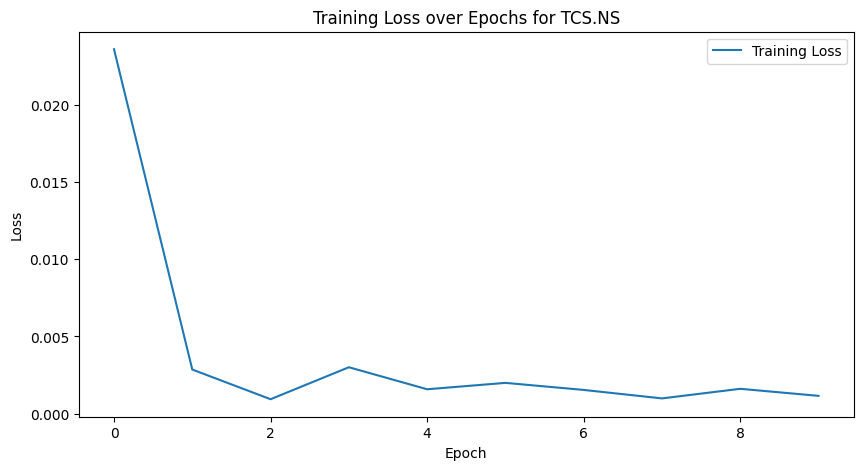

TCS.NS - Mean Squared Error: 0.013262877240777016
TCS.NS - Mean Absolute Error: 0.09589726477861404


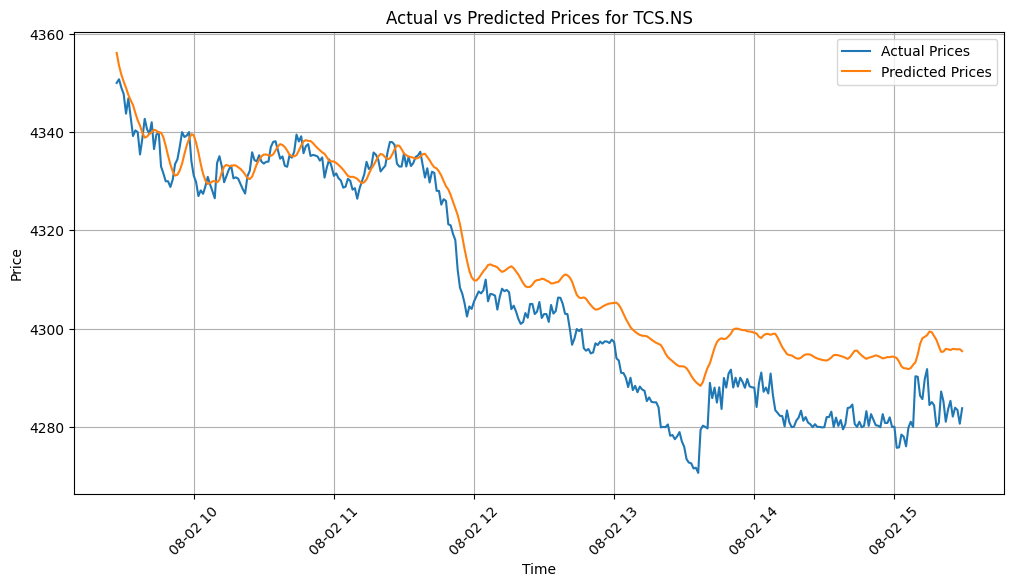

[*********************100%%**********************]  1 of 1 completed


Processing ADANIGREEN.NS...

Training data range: 2024-07-29 09:15:00+05:30 to 2024-08-02 09:26:00+05:30
Testing data range: 2024-08-02 09:27:00+05:30 to 2024-08-02 15:29:00+05:30


Epoch [1/10], Loss: 0.0085
Epoch [2/10], Loss: 0.0037
Epoch [3/10], Loss: 0.0012
Epoch [4/10], Loss: 0.0059
Epoch [5/10], Loss: 0.0014
Epoch [6/10], Loss: 0.0062
Epoch [7/10], Loss: 0.0039
Epoch [8/10], Loss: 0.0034
Epoch [9/10], Loss: 0.0022
Epoch [10/10], Loss: 0.0028


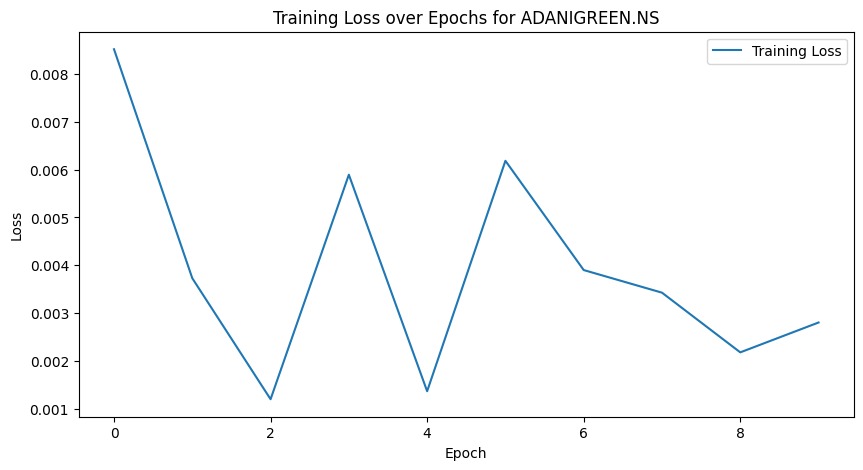

ADANIGREEN.NS - Mean Squared Error: 0.001392997452057898
ADANIGREEN.NS - Mean Absolute Error: 0.028397036716341972


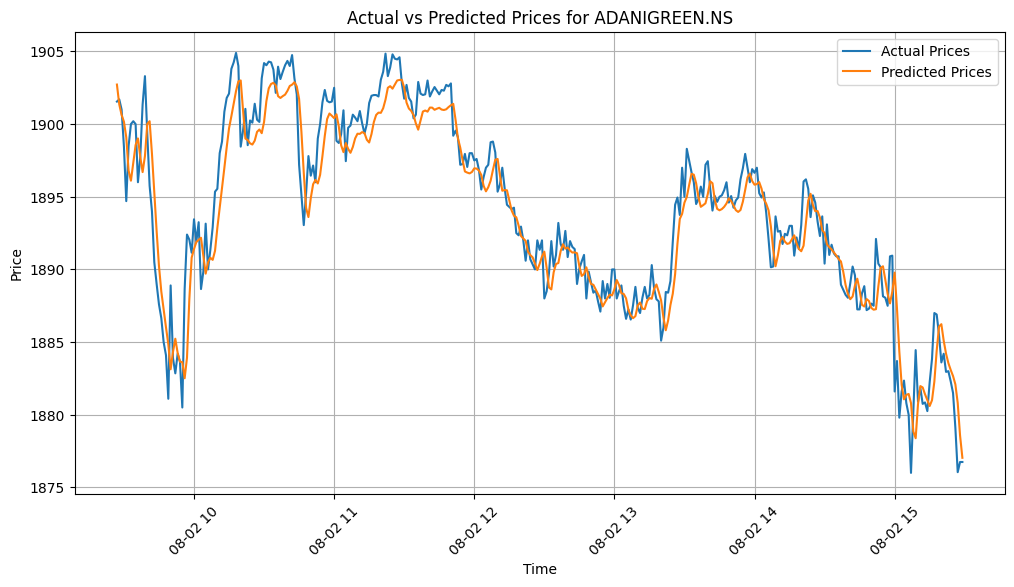

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.autograd import Variable
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. Download the data
def download_data_in_chunks(ticker, start_date, end_date, interval):
    data = pd.DataFrame()
    current_start = start_date
    while current_start < end_date:
        current_end = (datetime.strptime(current_start, '%Y-%m-%d') + timedelta(days=7)).strftime('%Y-%m-%d')
        if current_end > end_date:
            current_end = end_date
        chunk = yf.download(ticker, start=current_start, end=current_end, interval=interval)
        data = pd.concat([data, chunk])
        current_start = current_end
    return data

# 2. Preprocess the data
def preprocess_data(data):
    data = data[['Close']]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# 3. Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 4. Define the LTCN model
class LTCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LTCN, self).__init__()
        self.hidden_size = hidden_size
        self.ltc = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(x.device)
        out, hn = self.ltc(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 5. Train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs, device):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        for sequences, targets in train_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return loss_list

# 6. Evaluate the model
def evaluate_model(model, criterion, test_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            outputs = model(sequences)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    return predictions, actuals, mse, mae

# Plot the predicted vs actual prices with more details
def plot_predictions(ticker, actuals, predictions, test_dates):
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, actuals, label='Actual Prices')
    plt.plot(test_dates, predictions, label='Predicted Prices')
    plt.title(f'Actual vs Predicted Prices for {ticker}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

# Updated main function call
def main(tickers, start_date=None, end_date=None, interval='1m'):
    seq_length = 60
    batch_size = 64
    hidden_size = 50
    num_epochs = 10
    learning_rate = 0.001

    if start_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
        start_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')  # Changed 30 to 7
    elif end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    results = {}
    for ticker in tickers:
        print(f"\nProcessing {ticker}...\n")
        data = download_data_in_chunks(ticker, start_date, end_date, interval=interval)
        if data.empty:
            print(f"No data found for {ticker} in the given date range.")
            continue

        scaled_data, scaler = preprocess_data(data)
        xs, ys = create_sequences(scaled_data, seq_length)

        # Split data into train and test sets
        train_size = int(len(xs) * 0.8)
        test_size = len(xs) - train_size
        train_xs, test_xs = xs[:train_size], xs[train_size:]
        train_ys, test_ys = ys[:train_size], ys[train_size:]

        # Get the date ranges for training and testing
        train_dates = data.index[:train_size + seq_length]
        test_dates = data.index[train_size + seq_length:]

        print(f'Training data range: {train_dates[0]} to {train_dates[-1]}')
        print(f'Testing data range: {test_dates[0]} to {test_dates[-1]}')

        train_xs = torch.tensor(train_xs, dtype=torch.float32)
        train_ys = torch.tensor(train_ys, dtype=torch.float32)
        test_xs = torch.tensor(test_xs, dtype=torch.float32)
        test_ys = torch.tensor(test_ys, dtype=torch.float32)

        train_dataset = torch.utils.data.TensorDataset(train_xs, train_ys)
        test_dataset = torch.utils.data.TensorDataset(test_xs, test_ys)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        input_size = train_xs.shape[2]
        output_size = 1

        model = LTCN(input_size, hidden_size, output_size).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        loss_list = train_model(model, criterion, optimizer, train_loader, num_epochs, device)

        # Save the model
        torch.save(model.state_dict(), f'{ticker}_ltcn_model.pth')

        # Plot the loss curve
        plt.figure(figsize=(10, 5))
        plt.plot(loss_list, label='Training Loss')
        plt.title(f'Training Loss over Epochs for {ticker}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Evaluate the model
        predictions, actuals, mse, mae = evaluate_model(model, criterion, test_loader, device)
        predictions = scaler.inverse_transform(predictions)
        actuals = scaler.inverse_transform(actuals)

        print(f'{ticker} - Mean Squared Error: {mse}')
        print(f'{ticker} - Mean Absolute Error: {mae}')

        # Plot the predicted vs actual prices with more details
        plot_predictions(ticker, actuals, predictions, test_dates)

        results[ticker] = {
            'mse': mse,
            'mae': mae,
            'actuals': actuals,
            'predictions': predictions
        }

    return results

if __name__ == "__main__":
    tickers = ['RELIANCE.NS', 'TCS.NS', 'ADANIGREEN.NS']
    results = main(tickers, interval='1m')


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Download the data
def download_data(ticker, start_date, end_date, interval):
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    return data

# Preprocess the data
def preprocess_data(data):
    data = data[['Close']]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        xs.append(x)
    return np.array(xs)

# Define the LTCN model
class LTCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LTCN, self).__init__()
        self.hidden_size = hidden_size
        self.ltc = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(x.device)
        out, hn = self.ltc(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs, device):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        for sequences in train_loader:
            sequences = sequences[0].to(device)  # Get only the sequences, no targets
            outputs = model(sequences)
            targets = sequences[:, -1, :]  # Use the last element in the sequence as the target
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return loss_list

# Predict the next day's price at 1-minute intervals
def predict_next_day(model, last_sequence, device, num_predictions):
    model.eval()
    predictions = []
    with torch.no_grad():
        for _ in range(num_predictions):
            last_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)
            prediction = model(last_sequence)
            predictions.append(prediction.cpu().numpy())
            last_sequence = np.append(last_sequence[:, 1:, :], prediction.cpu().numpy().reshape(1, 1, -1), axis=1)
    return np.array(predictions)

# Plot the predicted prices for the next day at 1-minute intervals
def plot_predictions(ticker, last_date, predictions):
    next_dates = [last_date + timedelta(minutes=i) for i in range(len(predictions))]
    plt.figure(figsize=(12, 6))
    plt.plot(next_dates, predictions, 'r', label='Predicted Price')
    plt.title(f'Predicted Prices for {ticker} on {next_dates[0].strftime("%Y-%m-%d")}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Updated main function call
def main(tickers, interval='1m'):
    seq_length = 7 * 390  # 7 days of 390 minutes each (assuming 6.5 trading hours per day)
    batch_size = 64
    hidden_size = 50
    num_epochs = 10
    learning_rate = 0.001

    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')  # Last 7 days

    results = {}
    for ticker in tickers:
        print(f"\nProcessing {ticker}...\n")
        data = download_data(ticker, start_date, end_date, interval=interval)
        if data.empty:
            print(f"No data found for {ticker} in the given date range.")
            continue

        scaled_data, scaler = preprocess_data(data)
        xs = create_sequences(scaled_data, seq_length)

        if len(xs) == 0:
            print(f"Not enough data to create sequences for {ticker}.")
            continue

        # Use all data for training
        train_xs = xs

        train_xs = torch.tensor(train_xs, dtype=torch.float32)

        train_dataset = torch.utils.data.TensorDataset(train_xs)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        input_size = train_xs.shape[2]
        output_size = 1

        model = LTCN(input_size, hidden_size, output_size).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        loss_list = train_model(model, criterion, optimizer, train_loader, num_epochs, device)

        # Save the model
        torch.save(model.state_dict(), f'{ticker}_ltcn_model.pth')

        # Plot the loss curve
        plt.figure(figsize=(10, 5))
        plt.plot(loss_list, label='Training Loss')
        plt.title(f'Training Loss over Epochs for {ticker}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Predict the next day at 1-minute intervals (assuming 390 minutes of trading in a day)
        last_sequence = scaled_data[-seq_length:]
        predictions = predict_next_day(model, last_sequence, device, num_predictions=390)
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

        # Prepare date for plotting
        last_date = data.index[-1]

        print(f'Next day predictions for {ticker}: {predictions}')

        # Plot the predicted prices for the next day
        plot_predictions(ticker, last_date, predictions)

        results[ticker] = {
            'predictions': predictions
        }

    return results

if __name__ == "__main__":
    tickers = ['RELIANCE.NS', 'TCS.NS', 'ADANIGREEN.NS']
    results = main(tickers, interval='1m')
    print(results)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing RELIANCE.NS...

Not enough data to create sequences for RELIANCE.NS.

Processing TCS.NS...

Not enough data to create sequences for TCS.NS.

Processing ADANIGREEN.NS...




[*********************100%%**********************]  1 of 1 completed

Not enough data to create sequences for ADANIGREEN.NS.
{}


In [ ]:
amount = 1000
r = 2
for

0 1.023292992280754
1 1.0002302850208247
2 1.000002302587744
3 1.0000000230258512
4 1.0000000002302585
5 1.0000000000023026
6 1.000000000000023
7 1.0000000000000002
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 1.0
17 1.0
18 1.0
19 1.0
20 1.0
21 1.0
22 1.0
23 1.0
24 1.0
25 1.0
26 1.0
27 1.0
28 1.0
29 1.0
